In [42]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nice
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# 1. Load your processed data from Task 1 (to see dates and tickers)
news_df = pd.read_csv("../data/processed/task1_processed.csv")

# Let's pick ONE stock to start (e.g., AAPL). 
# In the real world, you loop through all of them later.
TARGET_STOCK = "AAPL"

In [43]:
# Check date range in your news data
news_df['date'] = pd.to_datetime(news_df['date'], utc=True)
min_date = news_df['date'].min().date()
max_date = news_df['date'].max().date()

print(f"News data covers: {min_date} to {max_date}")

# Fetch stock data from Yahoo Finance
# We add a buffer to start_date to calculate Moving Averages correctly at the beginning
stock_data = yf.download(TARGET_STOCK, start="2010-01-01", end="2024-01-01")

print(stock_data.head())

News data covers: 2011-04-28 to 2020-06-11


C:\Users\hp\AppData\Local\Temp\ipykernel_8812\2458082491.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(TARGET_STOCK, start="2010-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.418384  6.433080  6.369499  6.400989  493729600
2010-01-05  6.429481  6.465770  6.395591  6.436079  601904800
2010-01-06  6.327210  6.454972  6.320612  6.429479  552160000
2010-01-07  6.315513  6.358101  6.269627  6.350603  477131200
2010-01-08  6.357502  6.358102  6.269928  6.307117  447610800


In [45]:
# TA-Lib requires simple 1D arrays (numpy) or Pandas Series
# Ensure we are using the 'Close' price (Adjusted Close is often better, but Close is standard)

# 1. Simple Moving Average (SMA) - 20 Days
stock_data['SMA_20'] = talib.SMA(stock_data['Close'].squeeze(), timeperiod=20)

# 2. RSI - 14 Days (Standard)
stock_data['RSI'] = talib.RSI(stock_data['Close'].squeeze(), timeperiod=14)

# 3. MACD
# MACD returns 3 things: The MACD line, the Signal line, and the Histogram
macd, macd_signal, macd_hist = talib.MACD(stock_data['Close'].squeeze(), fastperiod=12, slowperiod=26, signalperiod=9)
stock_data['MACD'] = macd
stock_data['MACD_Signal'] = macd_signal

# check results
stock_data.tail()

Price,Close,High,Low,Open,Volume,SMA_20,RSI,MACD,MACD_Signal
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,
Date,,,,,,,,,
2023-12-22,191.788757,193.581821,191.164647,193.353962,37149600,191.856615,54.672791,2.633141,3.235256
2023-12-26,191.243912,192.076049,191.025969,191.798670,28919300,192.018090,53.090055,2.304752,3.049155
2023-12-27,191.342972,191.689703,189.302247,190.689158,48087700,192.154304,53.354453,2.029104,2.845145
2023-12-28,191.768967,192.838865,191.362799,192.323725,34049900,192.362836,54.541047,1.823999,2.640916
2023-12-29,190.728775,192.581275,189.936256,192.085953,42672100,192.490631,51.121347,1.559540,2.424641


In [46]:
# Daily Returns (Percentage change from previous day)
stock_data['Daily_Return'] = stock_data['Close'].pct_change()

# Log Returns (Often preferred for statistical analysis)
stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

# Rolling Volatility (Standard Deviation of returns) - 20 day window
stock_data['Volatility'] = stock_data['Daily_Return'].rolling(window=20).std()

stock_data.dropna(inplace=True) # Clean up the NaNs created by lagging

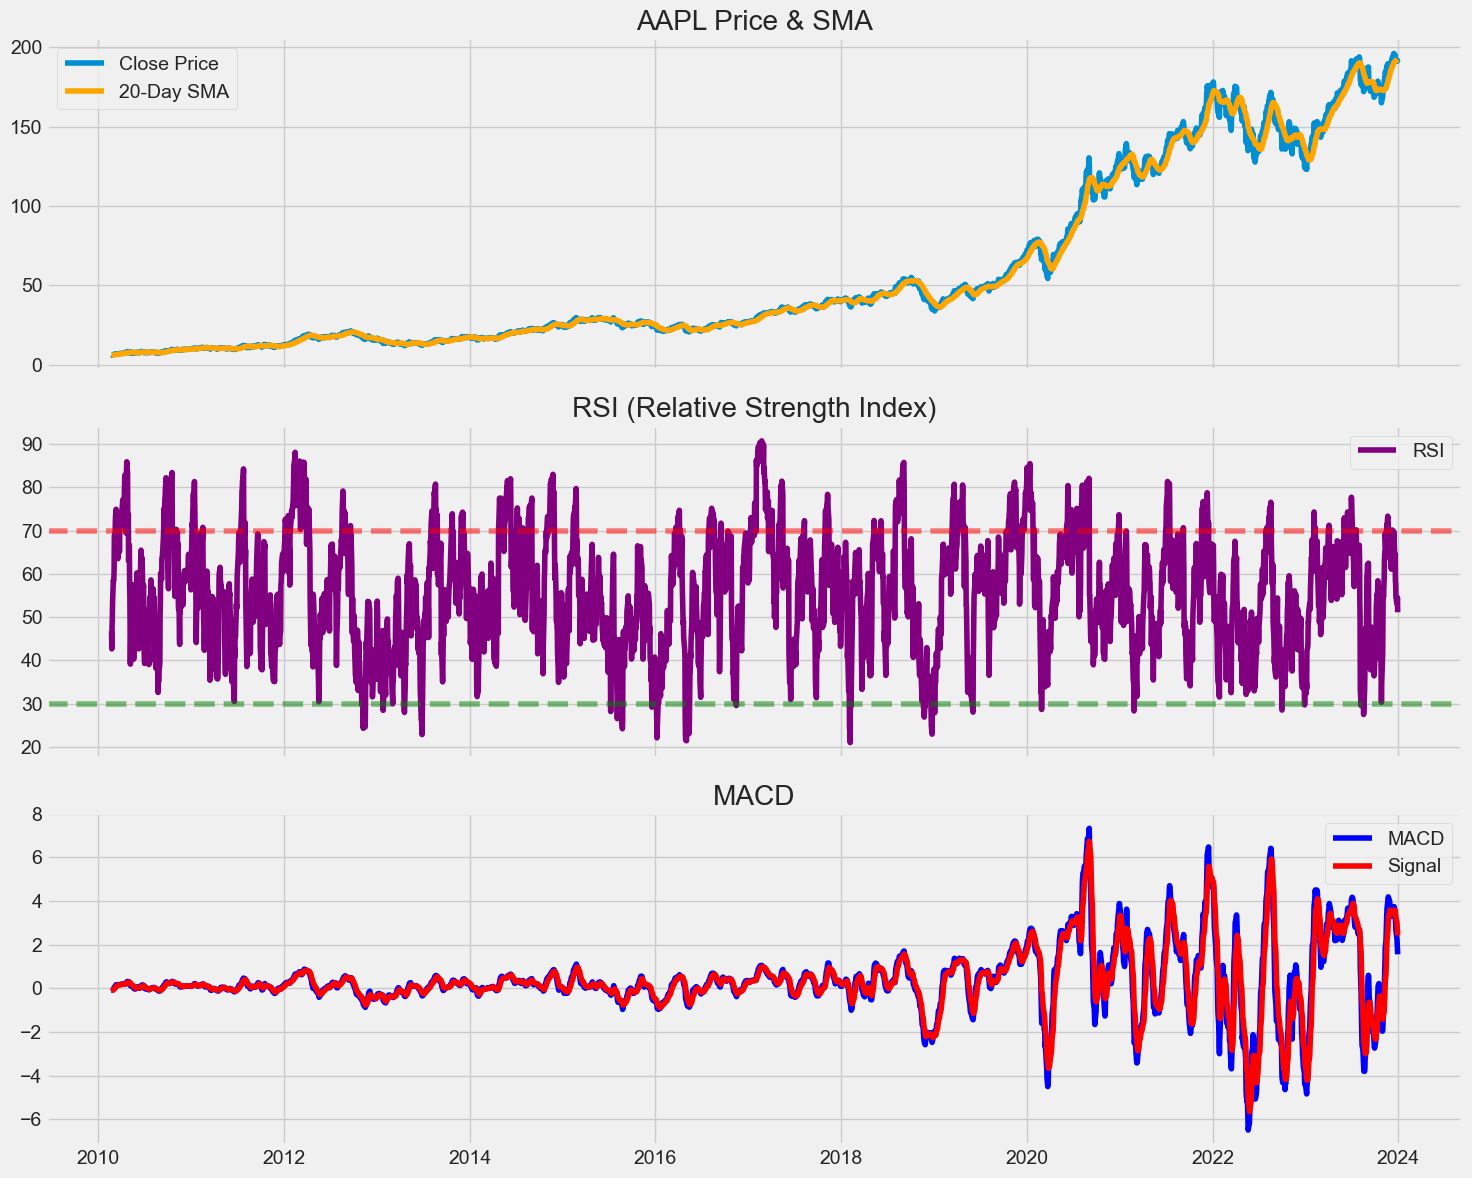

In [47]:
# Create a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot 1: Price and SMA
ax1.plot(stock_data.index, stock_data['Close'], label='Close Price')
ax1.plot(stock_data.index, stock_data['SMA_20'], label='20-Day SMA', color='orange')
ax1.set_title(f'{TARGET_STOCK} Price & SMA')
ax1.legend()

# Plot 2: RSI
ax2.plot(stock_data.index, stock_data['RSI'], label='RSI', color='purple')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5) # Overbought
ax2.axhline(30, color='green', linestyle='--', alpha=0.5) # Oversold
ax2.set_title('RSI (Relative Strength Index)')
ax2.legend()

# Plot 3: MACD
ax3.plot(stock_data.index, stock_data['MACD'], label='MACD', color='blue')
ax3.plot(stock_data.index, stock_data['MACD_Signal'], label='Signal', color='red')
ax3.set_title('MACD')
ax3.legend()

plt.tight_layout()
plt.show()

In [48]:
## 6. Save Processed Stock Data

# Reset the index to turn the 'Date' index into a column 
# This makes it easier to merge with the news_df later in Task 3.
stock_data_final = stock_data.reset_index()

# Rename the date column to match the news data structure for consistency
stock_data_final.rename(columns={'Date': 'date_only'}, inplace=True) 

# Select only the columns you need for the next task and analysis
final_columns = [
    'date_only', 'Close', 'Daily_Return', 'SMA_20', 'RSI', 'MACD', 'Volatility'
]
stock_data_final = stock_data_final[final_columns]

# Ensure the 'date_only' is in the correct format (date string)
stock_data_final['date_only'] = stock_data_final['date_only'].dt.date

# Create the processed directory if it doesn't exist (good Data Engineering practice)
import os
os.makedirs('../data/processed', exist_ok=True)

# Save the file
output_file_path = f'../data/processed/{TARGET_STOCK}_processed_stock_data.csv'
stock_data_final.to_csv(output_file_path, index=False)

print(f"Successfully saved processed stock data for {TARGET_STOCK} to: {output_file_path}")
print(stock_data_final.head())

Successfully saved processed stock data for AAPL to: ../data/processed/AAPL_processed_stock_data.csv
Price    date_only     Close Daily_Return    SMA_20        RSI      MACD  \
Ticker                  AAPL                                               
0       2010-02-22  6.010806    -0.006198  5.969747  46.780613 -0.074591   
1       2010-02-23  5.910037    -0.016765  5.960735  42.664776 -0.076816   
2       2010-02-24  6.018002     0.018268  5.952817  47.948809 -0.069071   
3       2010-02-25  6.058190     0.006678  5.944000  49.803283 -0.059010   
4       2010-02-26  6.136767     0.012970  5.951992  53.306180 -0.044187   

Price  Volatility  
Ticker             
0        0.019302  
1        0.018659  
2        0.018862  
3        0.018791  
4        0.016479  
